# Graphical Analysis of AI Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different AI GitHub repositories.

In [56]:
import time
start_time = time.time()

In [57]:
import pandas as pd
import collections

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sqlalchemy import create_engine, text

## Connect to the Augur database

In [58]:
with open("data/il_ai_creds.json") as config_file:
    config = json.load(config_file)
    
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

connection_string = database_connection_string
engine = create_engine(connection_string)

## Load the urls of AI repositories

- There are different verticals like math, nlp, gen_ai, personal_assistants, llm etc
- In this notebook, we are performing our analysis on math repositories as graphicals interpretation will be too messy if we try to plot all at once
- If you want to perform the same analysis on other verticals, just replace math with your choice in data.get('math)
- If you want to perofrm the analysis on all repositories at once, uncomment the cell following the below cell

In [59]:
f = open('ai_repos.json')
data = json.load(f)
f.close()

repo_git_set = []

repo_git_set = data.get('math')

In [60]:
# for key in data.keys():
#     repo_git_set.extend(data.get(key))

## Retrieve the repository IDs and the repository names

In [61]:
repo_set = []
repo_name_set = []

for repo_git in repo_git_set:
    repo_query = text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = \'{repo_git}\'
            """)

    # Using the connection to execute the query
    with engine.connect() as connection:
        t = connection.execute(repo_query)
        results = t.mappings().all()
        if results:
            repo_id = results[0]['repo_id']
            repo_name = results[0]['repo_name']
        else:
            repo_id = None
            repo_name = None
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)

print(repo_set)
print(repo_name_set)


[25495, 25498, 25497, 25501, 25500, 25504, 25503, 25496, 25502, 25499]
['numpy', 'tensorflow', 'networkx', 'pytorch', 'keras-io', 'tinygrad', 'pandas', 'polaris', 'arrow', 'mlx']


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [62]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    if not repo_id:
        continue
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        prm.cntrb_id,
                        prm.pull_request_id
                    FROM
                        repo r, pull_request_meta prm
                    WHERE
                        prm.repo_id = \'{repo_id}\' AND
                        prm.repo_id = r.repo_id
                    LIMIT 50000
                """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']
display(pr_contrib)
pr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25495,numpy,https://github.com/numpy/numpy,0100070f-d200-0000-0000-000000000000,44059
1,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,44059
2,25495,numpy,https://github.com/numpy/numpy,01021893-0d00-0000-0000-000000000000,73996
3,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,73996
4,25495,numpy,https://github.com/numpy/numpy,0100012d-d800-0000-0000-000000000000,44012
...,...,...,...,...,...
251293,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,533187
251294,25499,mlx,https://github.com/ml-explore/mlx,01001b42-cd00-0000-0000-000000000000,41335
251295,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,41335
251296,25499,mlx,https://github.com/ml-explore/mlx,0100a3b8-0700-0000-0000-000000000000,40862


repo_id             int64
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id     int64
dtype: object

### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [63]:
prr_contrib = pd.DataFrame()

for repo_id in repo_set:
    if not repo_id:
        continue
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        prr.cntrb_id,
                        prr.pull_request_id
                    FROM
                        repo r, pull_request_reviews prr
                    WHERE
                        prr.repo_id = \'{repo_id}\' AND
                        prr.repo_id = r.repo_id
                """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
prr_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']
display(prr_contrib)
prr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62697
1,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62681
2,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62586
3,25500,keras-io,https://github.com/keras-team/keras-io,01001535-7100-0000-0000-000000000000,62486
4,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62386
...,...,...,...,...,...
2156,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41463
2157,25499,mlx,https://github.com/ml-explore/mlx,01008439-5300-0000-0000-000000000000,41391
2158,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41324
2159,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41250


repo_id            object
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [64]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    if not repo_id:
        continue
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        ca.cntrb_id,
                        c.cmt_id
                    FROM
                        repo r, commits c, contributors_aliases ca
                    WHERE
                        c.repo_id = \'{repo_id}\' AND
                        c.repo_id = r.repo_id and
                        c.cmt_committer_email = ca.alias_email
                """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'cmt_id']
display(commit_contrib)
commit_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,cmt_id
0,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,505655
1,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,505656
2,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401510
3,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401511
4,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401512
...,...,...,...,...,...
2044272,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3766970
2044273,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3766971
2044274,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3777299
2044275,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3777300


repo_id       int64
repo_name    object
repo_git     object
cntrb_id     object
cmt_id        int64
dtype: object

## Representing Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributor Graph

In [65]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,01000002-5600-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-0900-0000-0000-000000000000,01000009-ae00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,0100000a-ae00-0000-0000-000000000000,0100000f-7700-0000-0000-000000000000,01000010-bb00-0000-0000-000000000000,...,0108a5b7-ff00-0000-0000-000000000000,0108a6f1-9e00-0000-0000-000000000000,0108c567-ba00-0000-0000-000000000000,0108eb97-de00-0000-0000-000000000000,01091e7c-1b00-0000-0000-000000000000,0109ff1f-4600-0000-0000-000000000000,010a209b-dc00-0000-0000-000000000000,010a36e9-1e00-0000-0000-000000000000,010a42c5-1000-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,0,0,0,0,0,0,0,0,26,0,...,0,0,0,0,0,0,0,0,0,0
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
numpy,0,0,0,1,0,0,0,0,0,0,...,0,0,5,0,3,0,1,0,0,0


In the above dataframe, each row represents a repository name and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a number x means that the contributor has made x number of commits to the repository.

In [66]:
df_commit = df_commit.reset_index()
df_commit.head()

cntrb_id,repo_name,01000002-5600-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-0900-0000-0000-000000000000,01000009-ae00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,0100000a-ae00-0000-0000-000000000000,0100000f-7700-0000-0000-000000000000,...,0108a5b7-ff00-0000-0000-000000000000,0108a6f1-9e00-0000-0000-000000000000,0108c567-ba00-0000-0000-000000000000,0108eb97-de00-0000-0000-000000000000,01091e7c-1b00-0000-0000-000000000000,0109ff1f-4600-0000-0000-000000000000,010a209b-dc00-0000-0000-000000000000,010a36e9-1e00-0000-0000-000000000000,010a42c5-1000-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
0,arrow,0,0,0,0,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
1,keras-io,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,mlx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,networkx,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,numpy,0,0,0,1,0,0,0,0,0,...,0,0,5,0,3,0,1,0,0,0


In [67]:
df_commit.head()

cntrb_id,repo_name,01000002-5600-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-0900-0000-0000-000000000000,01000009-ae00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,0100000a-ae00-0000-0000-000000000000,0100000f-7700-0000-0000-000000000000,...,0108a5b7-ff00-0000-0000-000000000000,0108a6f1-9e00-0000-0000-000000000000,0108c567-ba00-0000-0000-000000000000,0108eb97-de00-0000-0000-000000000000,01091e7c-1b00-0000-0000-000000000000,0109ff1f-4600-0000-0000-000000000000,010a209b-dc00-0000-0000-000000000000,010a36e9-1e00-0000-0000-000000000000,010a42c5-1000-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
0,arrow,0,0,0,0,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
1,keras-io,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,mlx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,networkx,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,numpy,0,0,0,1,0,0,0,0,0,...,0,0,5,0,3,0,1,0,0,0


In [68]:
df_melted_commit = df_commit.melt(
    id_vars = ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [69]:
df_melted_commit.head()

,repo_name,cntrb_id,number
0,arrow,01000002-5600-0000-0000-000000000000,0
1,keras-io,01000002-5600-0000-0000-000000000000,0
2,mlx,01000002-5600-0000-0000-000000000000,0
3,networkx,01000002-5600-0000-0000-000000000000,0
4,numpy,01000002-5600-0000-0000-000000000000,0


In [70]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_name,cntrb_id,number
8,tensorflow,01000002-5600-0000-0000-000000000000,1
13,networkx,01000004-ca00-0000-0000-000000000000,1
28,tensorflow,01000006-8000-0000-0000-000000000000,1
34,numpy,01000007-8900-0000-0000-000000000000,1
48,tensorflow,01000009-0900-0000-0000-000000000000,12


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

In [71]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In the above cell, we created a graph object called G 

In [72]:
nodes = G.nodes()
# contributor_id = df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in repo_name_set else 'yellow' for n in nodes]

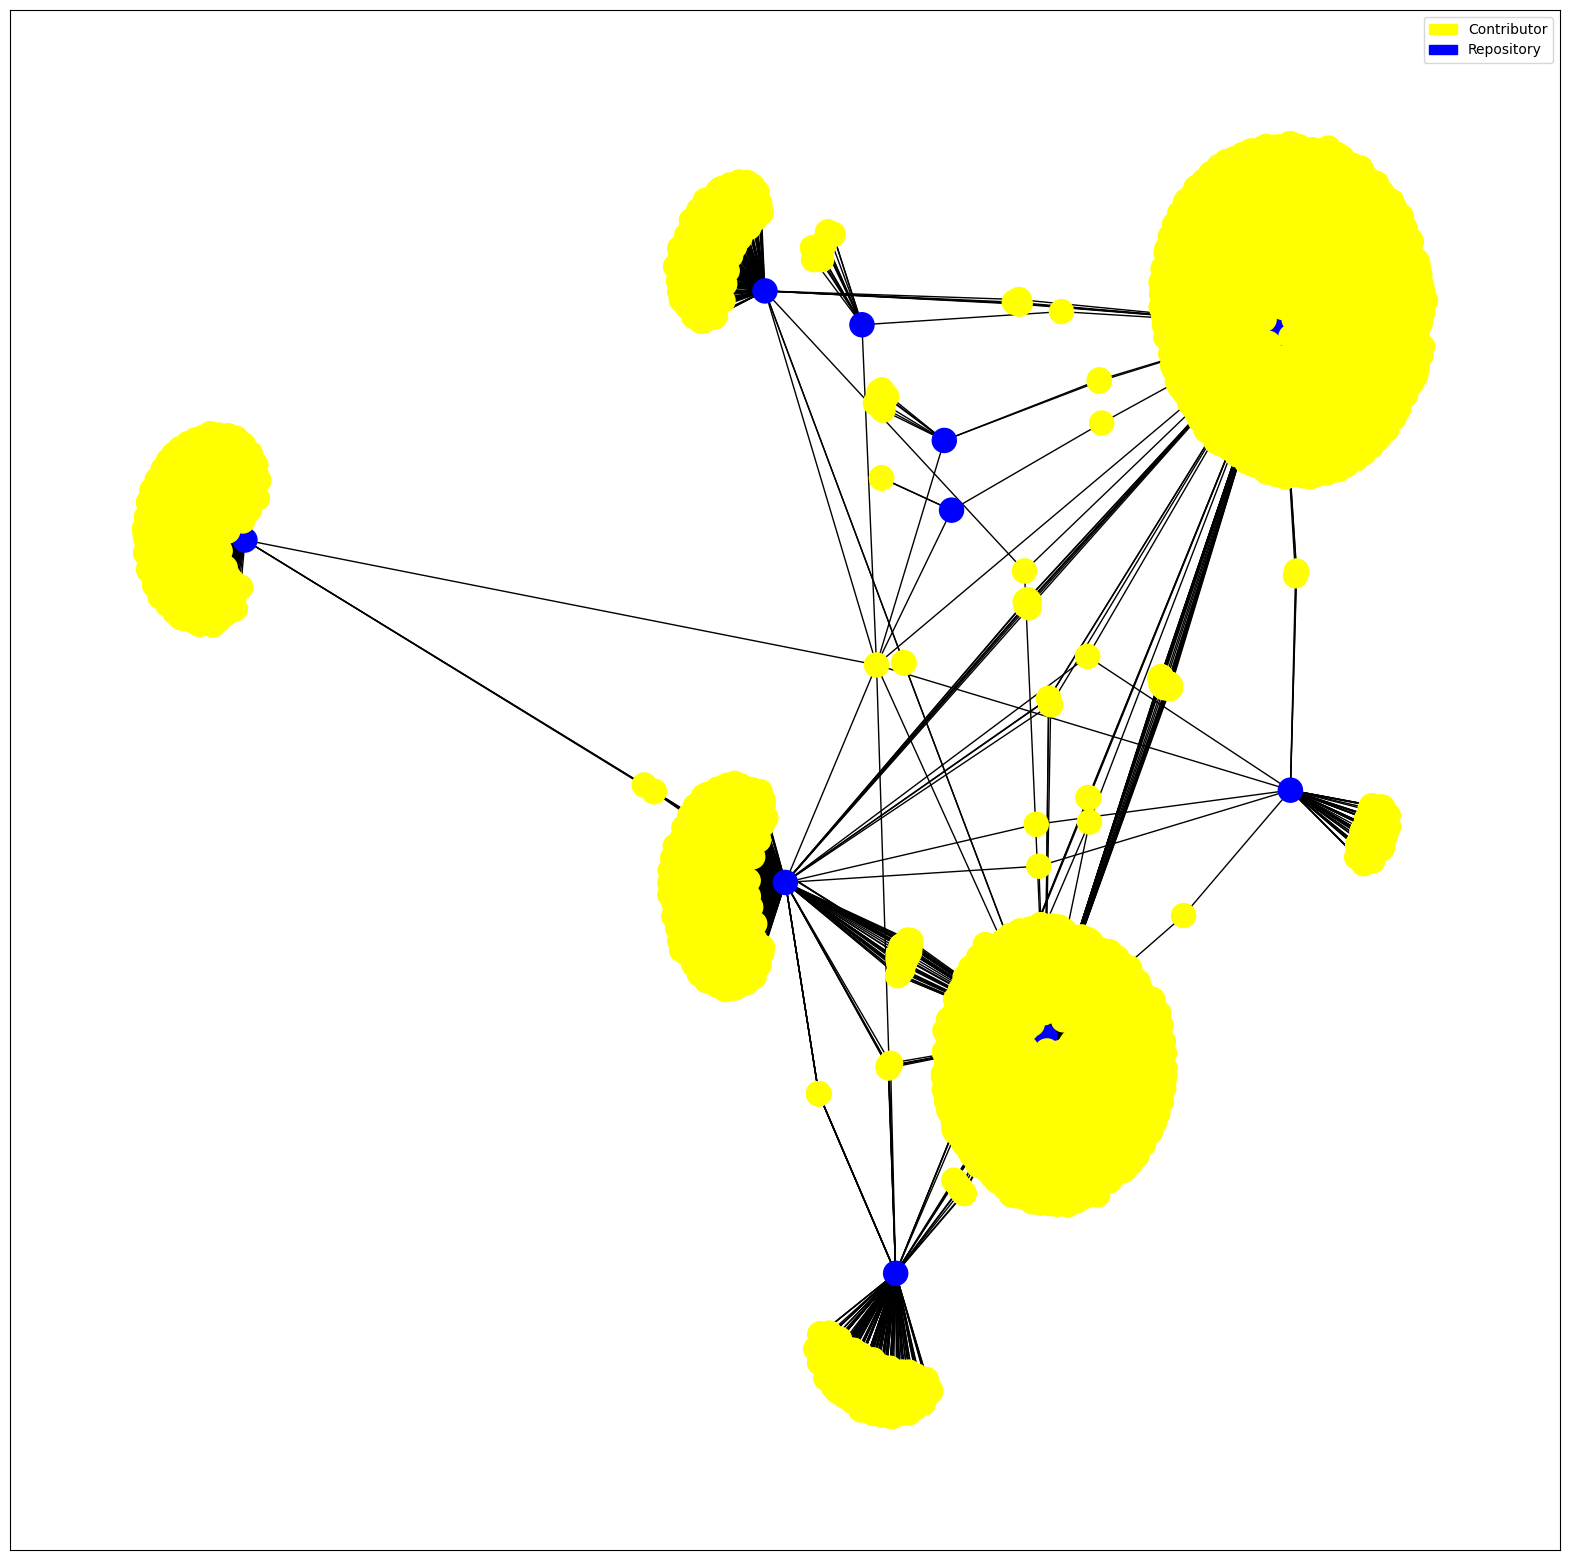

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Repository')
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=False)

What we see above is a certain set of repositories and their contributors plotted on the same graph. The blue dots represent project repositories and the yellow dots represent their contributors. This gives us an idea of central projects which have a large number of contributors and how other projects are connected to them. However, just given the number of repositories, this graph is hard to dig into, so lets subset this graph to create a smaller plot.

In [74]:
#subsetting the first 50 repo nodes for a smaller plot
smaller_df_melted_commit = df_melted_commit[0:50]

Here, we narrow down the entire set of nodes into view only 50 nodes plotted on a graph. Note, this is just for visual simplicilty. This is not a logical filtering and not all contributors for a project are going to be seen on the same plot

In [75]:
G = nx.from_pandas_edgelist(smaller_df_melted_commit, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [76]:
nodes = G.nodes()
Repo_id = smaller_df_melted_commit['repo_name'].to_list()
contributor_id = smaller_df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in repo_name_set else 'yellow' for n in nodes]

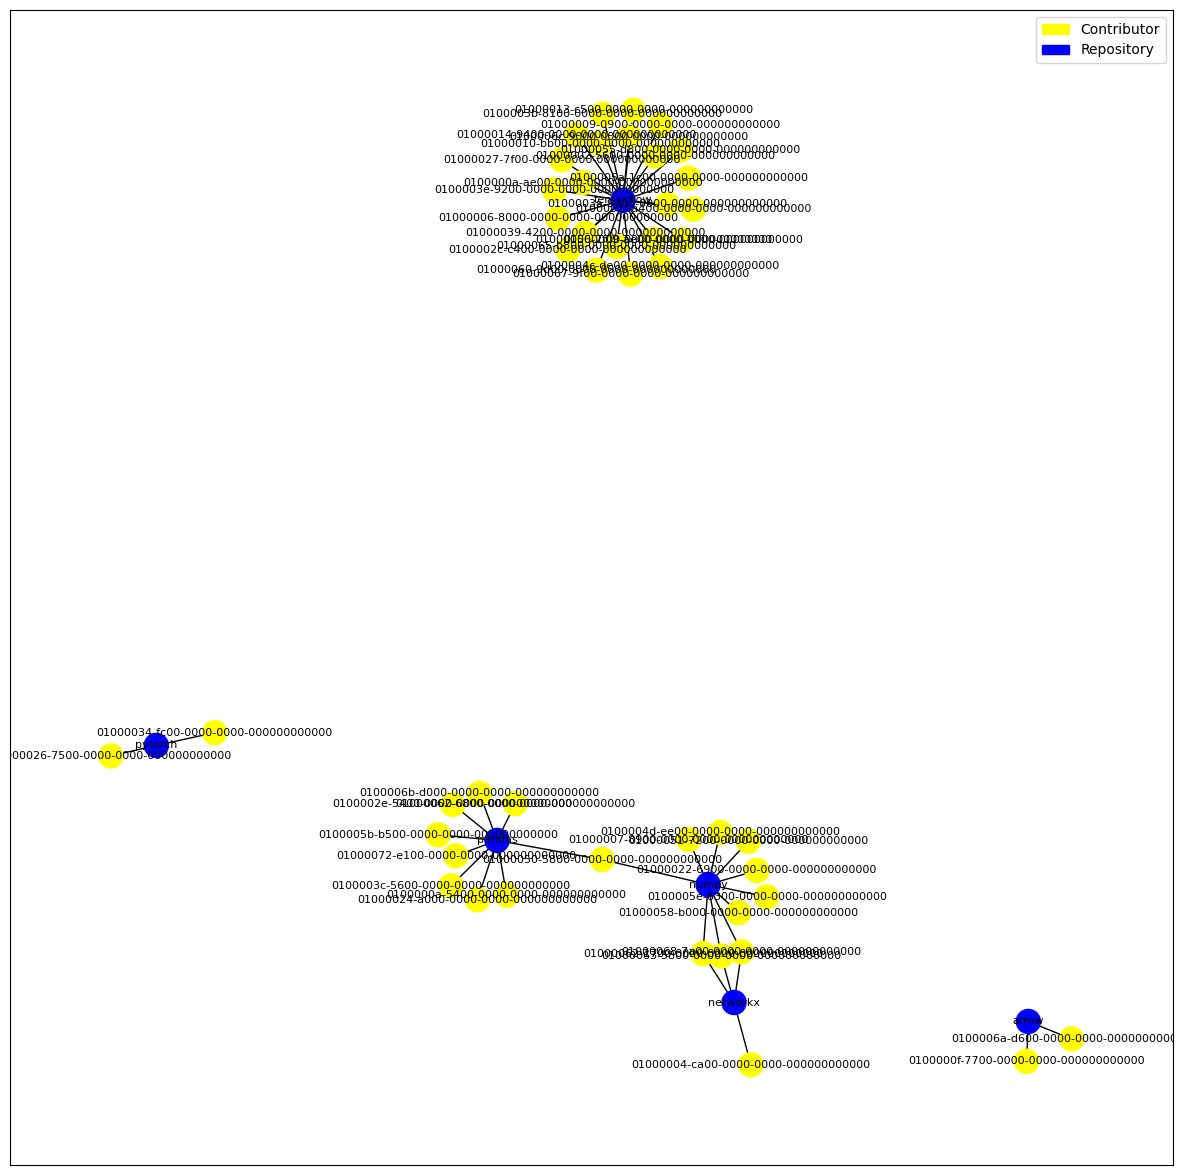

In [77]:
fig, ax = plt.subplots(figsize=(15,15))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=True)

### PR Contributor Graph

In [78]:
df_pr = pr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_pr.head()

cntrb_id,01000000-5000-0000-0000-000000000000,01000002-3300-0000-0000-000000000000,01000002-5600-0000-0000-000000000000,01000002-8100-0000-0000-000000000000,01000004-c700-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000004-e100-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000006-8600-0000-0000-000000000000,01000006-af00-0000-0000-000000000000,...,010a2a1a-0d00-0000-0000-000000000000,010a2aa0-dd00-0000-0000-000000000000,010a305c-e000-0000-0000-000000000000,010a575b-dd00-0000-0000-000000000000,010a5a96-3d00-0000-0000-000000000000,010a65e1-0a00-0000-0000-000000000000,010a6612-2d00-0000-0000-000000000000,010a7247-3d00-0000-0000-000000000000,010a7473-6500-0000-0000-000000000000,010a747f-ae00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,0,53,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
numpy,0,0,0,0,0,0,1,0,0,1,...,0,0,0,2,0,1,0,0,1,1


In [79]:
df_pr = df_pr.reset_index()

In [80]:
df_melted_pr = df_pr.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [81]:
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
df_melted_pr.head()

,repo_name,cntrb_id,number
8,tensorflow,01000000-5000-0000-0000-000000000000,3
10,arrow,01000002-3300-0000-0000-000000000000,53
28,tensorflow,01000002-5600-0000-0000-000000000000,3
35,pandas,01000002-8100-0000-0000-000000000000,1
45,pandas,01000004-c700-0000-0000-000000000000,3


In [82]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [83]:
nodes = G.nodes()
colors = ['blue' if n in repo_name_set else 'yellow' for n in nodes]

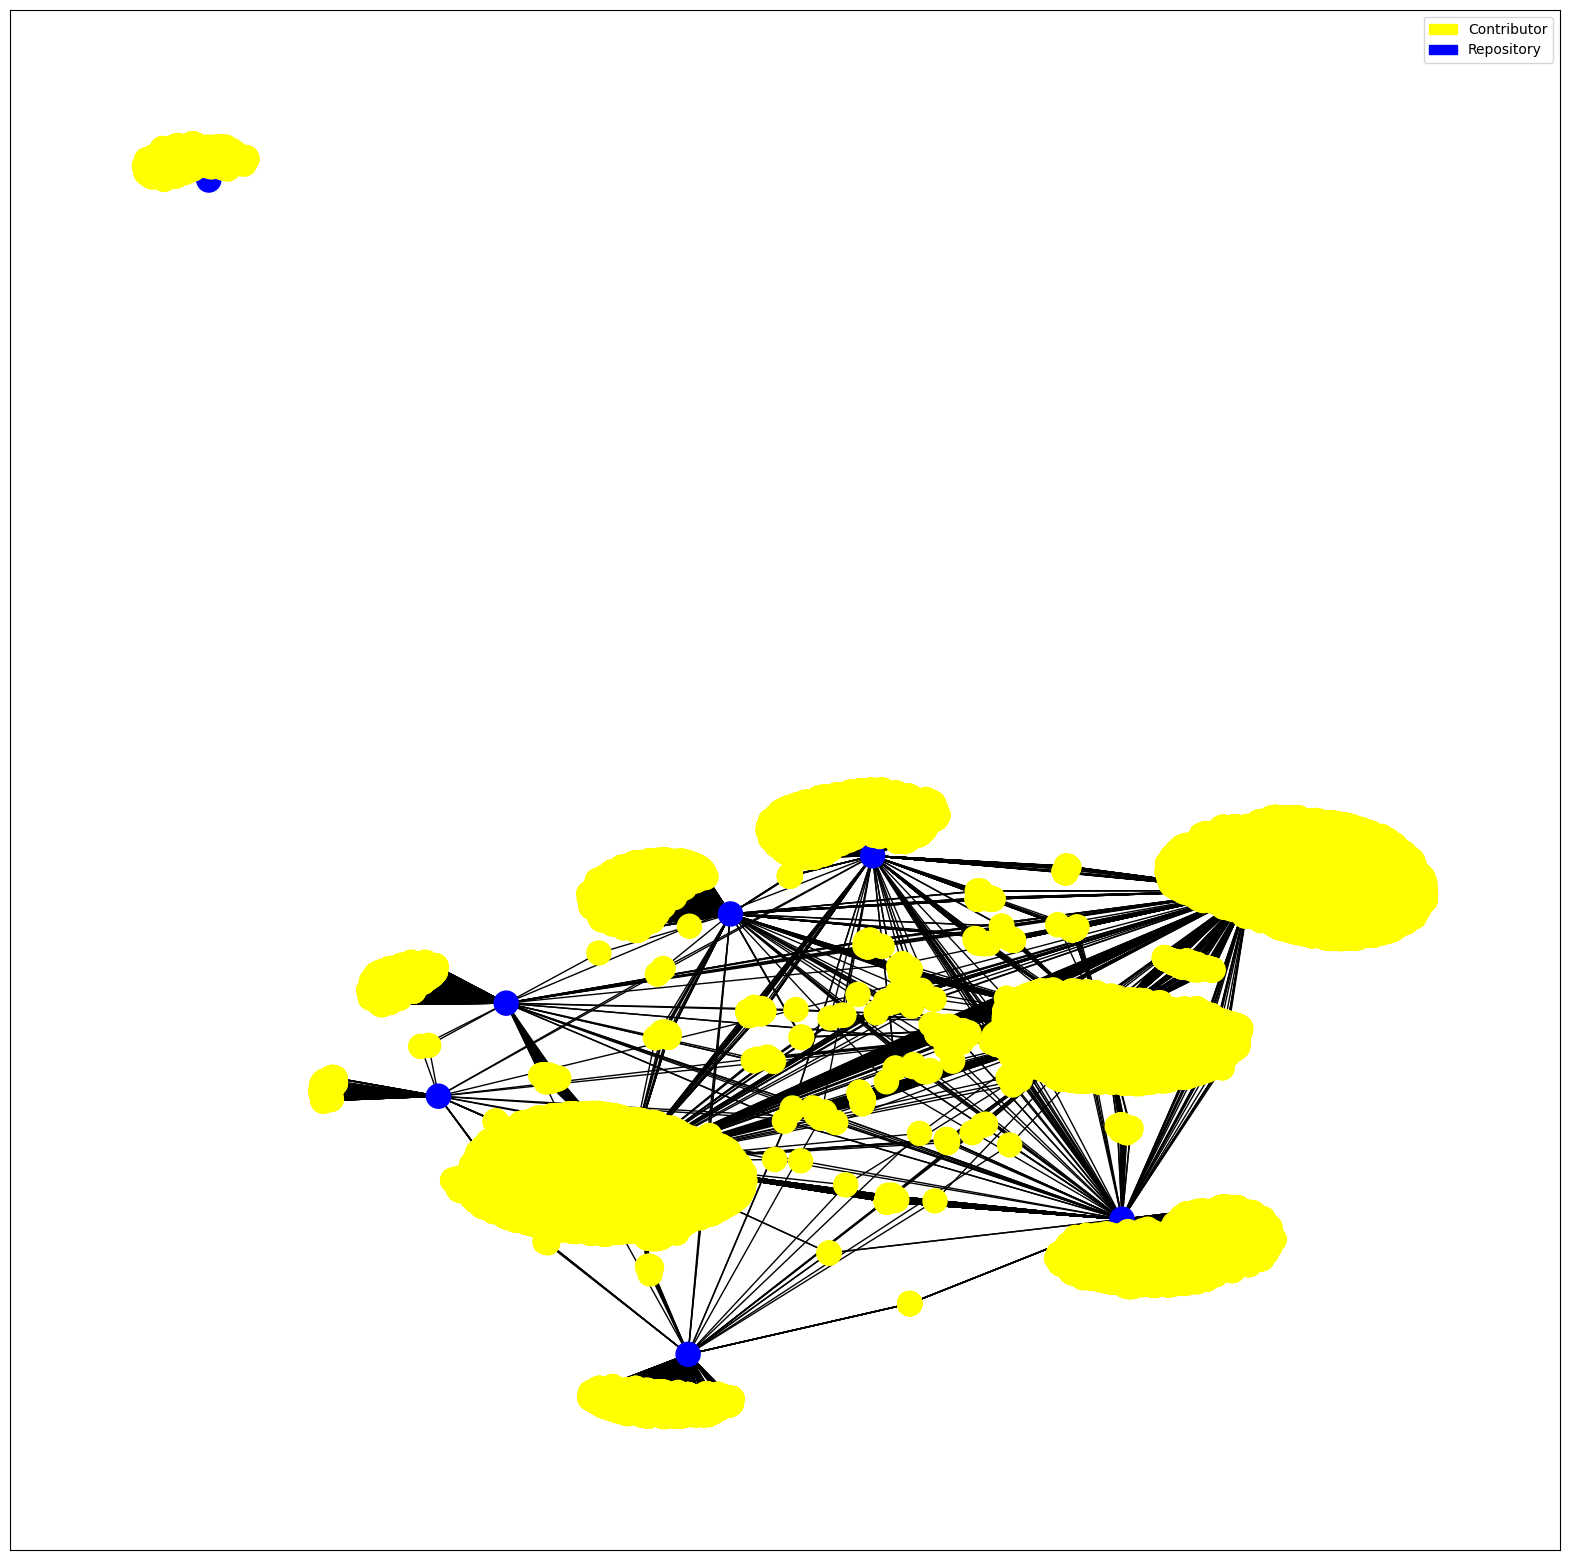

In [84]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=False)

In [85]:
smaller_df_melted_pr = df_melted_pr[0:50]

In [86]:
G = nx.from_pandas_edgelist(smaller_df_melted_pr, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [87]:
nodes = G.nodes()
colors = ['blue' if n in repo_name_set else 'yellow' for n in nodes]

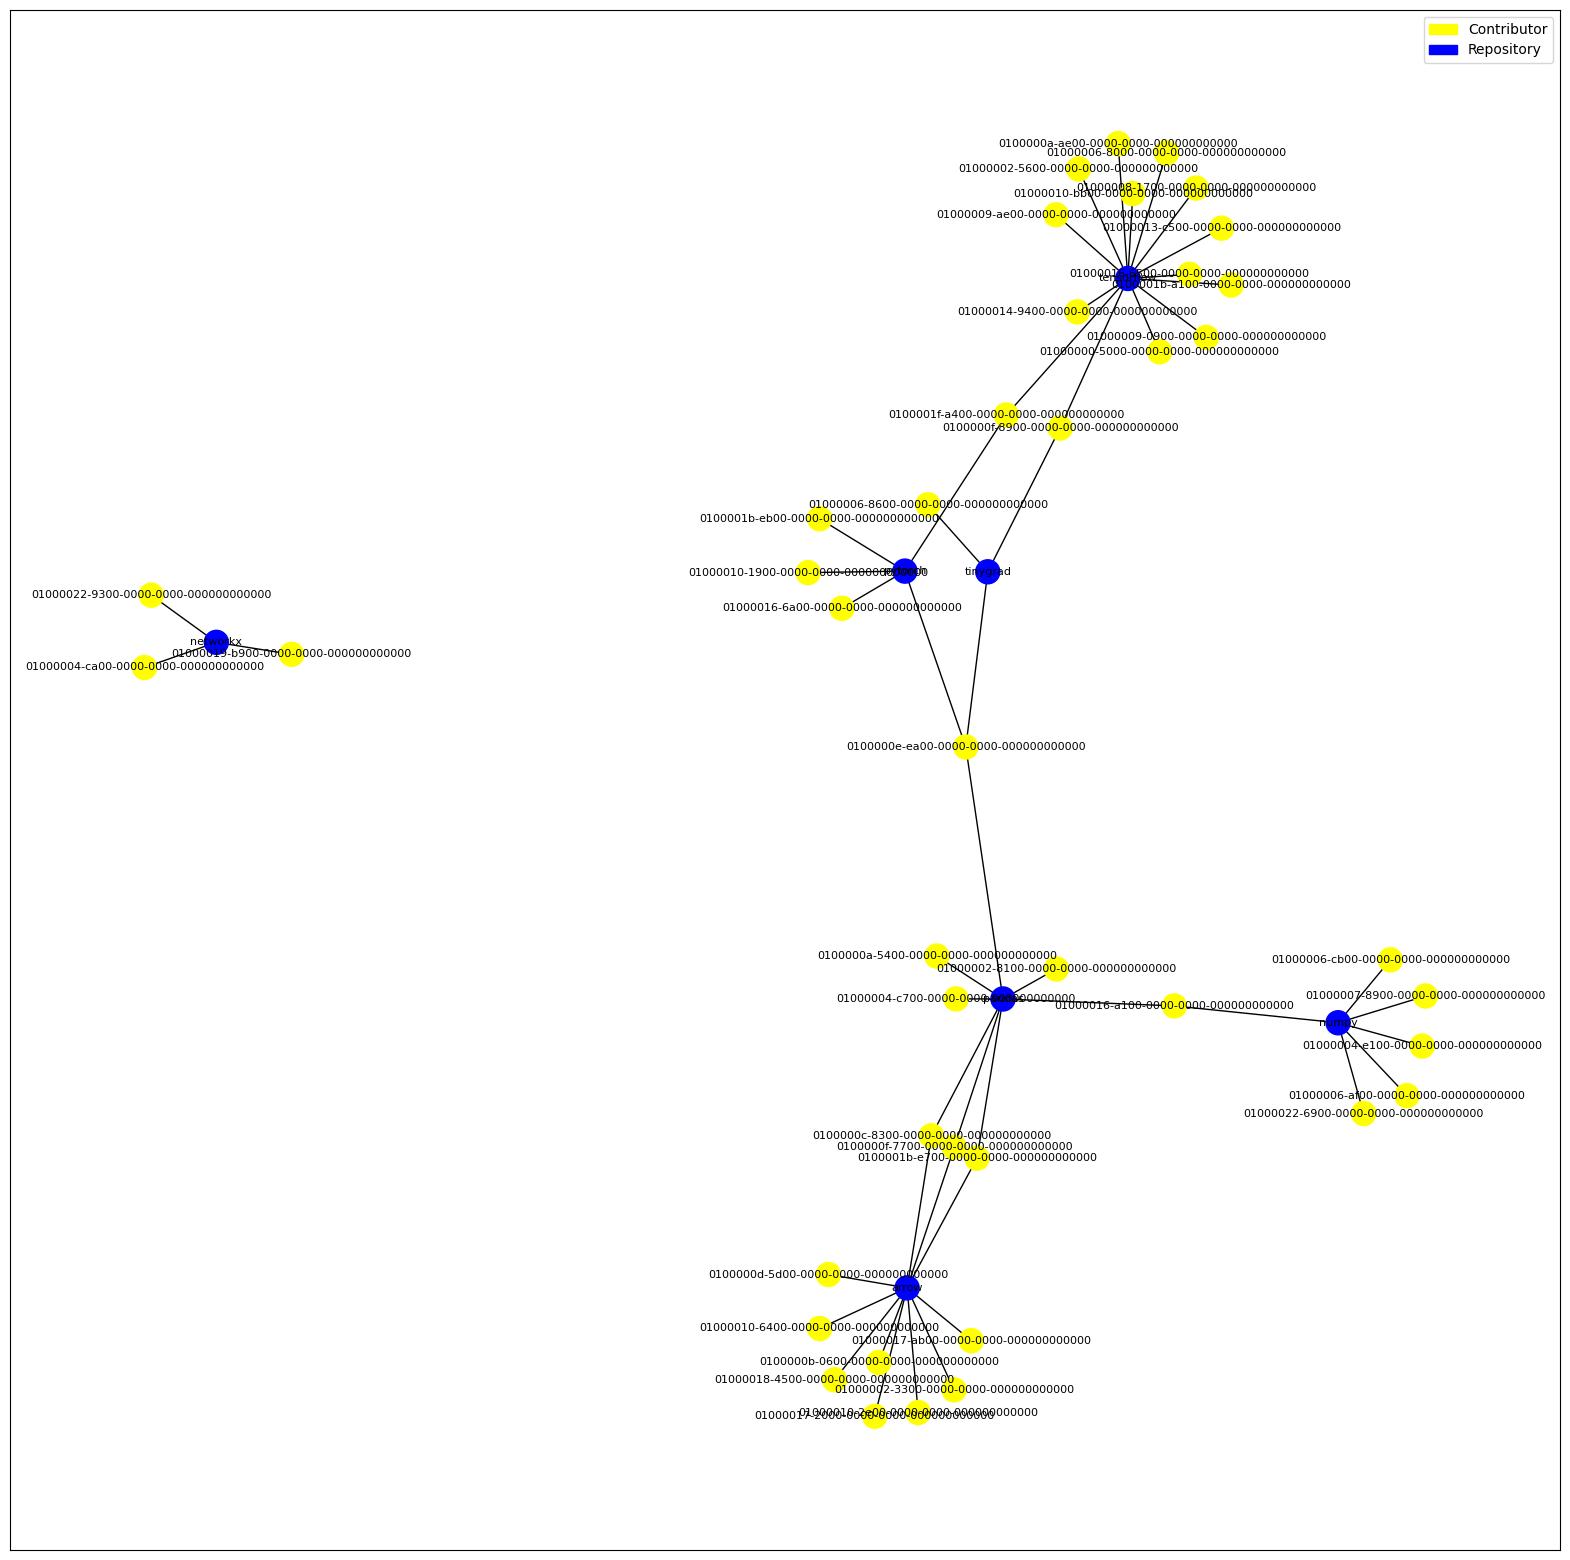

In [88]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=True)

### Pull Request Reviewer Contributor graph

In [89]:
df_prr = prr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_prr.head()

cntrb_id,0100004b-ed00-0000-0000-000000000000,01000054-2d00-0000-0000-000000000000,0100007b-7300-0000-0000-000000000000,010000a8-2b00-0000-0000-000000000000,010000cc-db00-0000-0000-000000000000,01000209-0f00-0000-0000-000000000000,0100023d-d500-0000-0000-000000000000,010002a9-e100-0000-0000-000000000000,010002ee-1e00-0000-0000-000000000000,01000477-6800-0000-0000-000000000000,...,010627eb-a600-0000-0000-000000000000,01065fd0-6d00-0000-0000-000000000000,01068af4-fe00-0000-0000-000000000000,0106aadf-9f00-0000-0000-000000000000,0106c734-bd00-0000-0000-000000000000,0106eafc-3a00-0000-0000-000000000000,0107163a-8900-0000-0000-000000000000,01085cb2-9600-0000-0000-000000000000,01094ec3-8f00-0000-0000-000000000000,01099b6f-be00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
keras-io,0,11,0,1,44,0,0,2,0,0,...,8,3,0,1,4,11,3,0,0,0
mlx,5,0,3,0,0,2,2,0,17,12,...,0,0,6,0,0,0,0,1,8,1


In [90]:
df_prr = df_prr.reset_index()

In [91]:
df_melted_prr = df_prr.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [92]:
df_melted_prr = df_melted_prr[df_melted_prr[df_melted_prr.columns[2]] != 0]
df_melted_prr.head()

,repo_name,cntrb_id,number
1,mlx,0100004b-ed00-0000-0000-000000000000,5
2,keras-io,01000054-2d00-0000-0000-000000000000,11
5,mlx,0100007b-7300-0000-0000-000000000000,3
6,keras-io,010000a8-2b00-0000-0000-000000000000,1
8,keras-io,010000cc-db00-0000-0000-000000000000,44


In [93]:
G = nx.from_pandas_edgelist(df_melted_prr, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [94]:
nodes = G.nodes()
colors = ['blue' if n in repo_name_set else 'yellow' for n in nodes]

In [95]:
nodes

NodeView(('mlx', UUID('0100004b-ed00-0000-0000-000000000000'), 'keras-io', UUID('01000054-2d00-0000-0000-000000000000'), UUID('0100007b-7300-0000-0000-000000000000'), UUID('010000a8-2b00-0000-0000-000000000000'), UUID('010000cc-db00-0000-0000-000000000000'), UUID('01000209-0f00-0000-0000-000000000000'), UUID('0100023d-d500-0000-0000-000000000000'), UUID('010002a9-e100-0000-0000-000000000000'), UUID('010002ee-1e00-0000-0000-000000000000'), UUID('01000477-6800-0000-0000-000000000000'), UUID('010009c2-7100-0000-0000-000000000000'), UUID('01000ad6-6f00-0000-0000-000000000000'), UUID('01000bd5-2a00-0000-0000-000000000000'), UUID('01000c18-dd00-0000-0000-000000000000'), UUID('01000c52-9c00-0000-0000-000000000000'), UUID('01000dfd-8000-0000-0000-000000000000'), UUID('01000ea5-6700-0000-0000-000000000000'), UUID('010010a5-d200-0000-0000-000000000000'), UUID('01001131-4a00-0000-0000-000000000000'), UUID('01001169-3500-0000-0000-000000000000'), UUID('010011b1-4500-0000-0000-000000000000'), UUID(

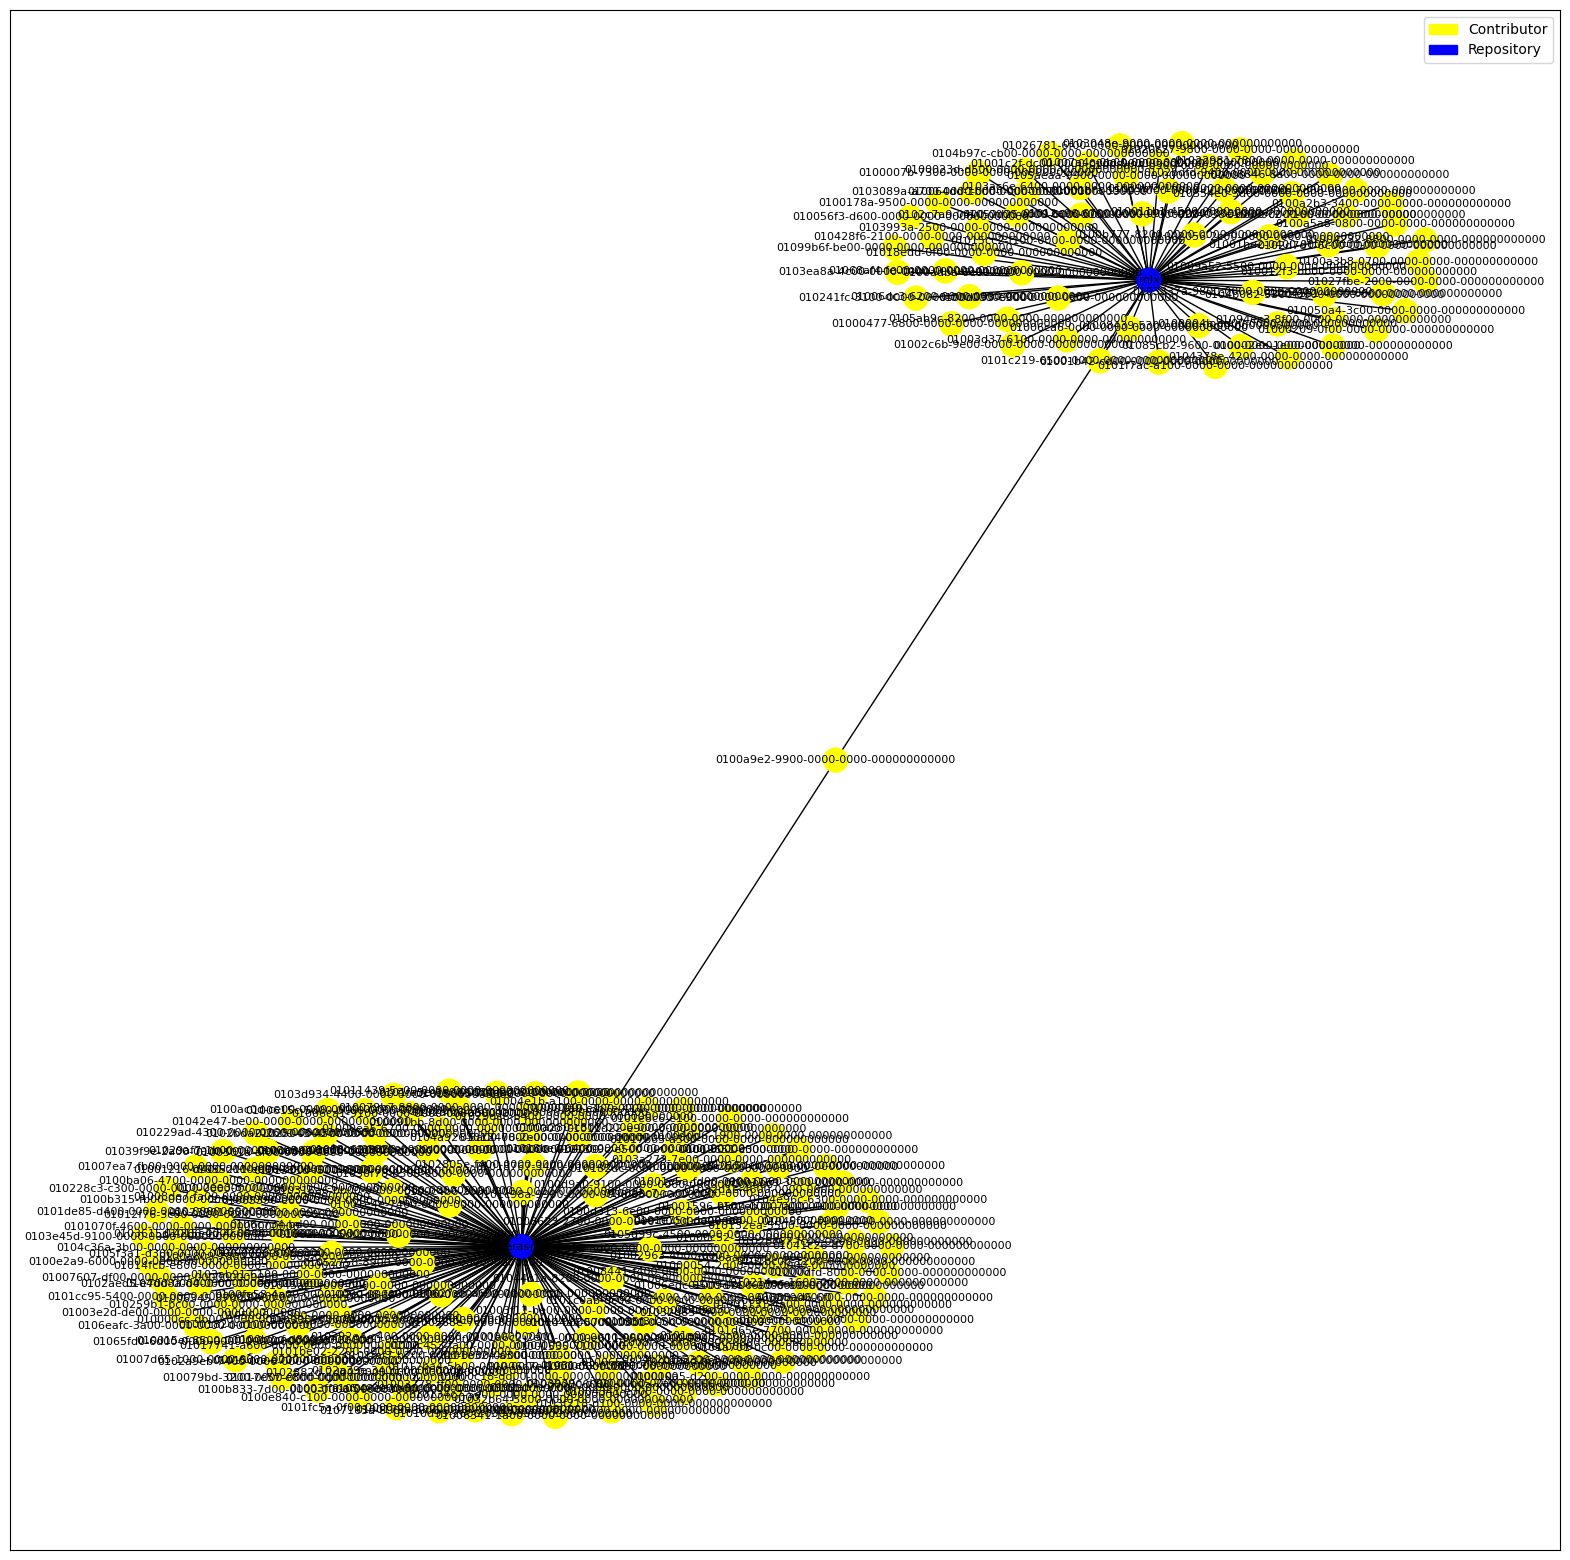

In [96]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=True)

## Representing projects as nodes and edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

Lets pick the **Pull Request** type contribution for these graph plots as an example

In [97]:
df_melted_pr.head()

,repo_name,cntrb_id,number
8,tensorflow,01000000-5000-0000-0000-000000000000,3
10,arrow,01000002-3300-0000-0000-000000000000,53
28,tensorflow,01000002-5600-0000-0000-000000000000,3
35,pandas,01000002-8100-0000-0000-000000000000,1
45,pandas,01000004-c700-0000-0000-000000000000,3


In [98]:
contributorGraph = {}
for i, row in df_melted_pr.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['number'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['number']))

In [99]:
list(contributorGraph.items())

[(UUID('01000000-5000-0000-0000-000000000000'), [('tensorflow', 3)]),
 (UUID('01000002-3300-0000-0000-000000000000'), [('arrow', 53)]),
 (UUID('01000002-5600-0000-0000-000000000000'), [('tensorflow', 3)]),
 (UUID('01000002-8100-0000-0000-000000000000'), [('pandas', 1)]),
 (UUID('01000004-c700-0000-0000-000000000000'), [('pandas', 3)]),
 (UUID('01000004-ca00-0000-0000-000000000000'), [('networkx', 1)]),
 (UUID('01000004-e100-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000006-8000-0000-0000-000000000000'), [('tensorflow', 2)]),
 (UUID('01000006-8600-0000-0000-000000000000'), [('tinygrad', 1)]),
 (UUID('01000006-af00-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000006-cb00-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000007-8900-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000008-1700-0000-0000-000000000000'), [('tensorflow', 1)]),
 (UUID('01000009-0900-0000-0000-000000000000'), [('tensorflow', 1)]),
 (UUID('01000009-ae00-0000-0000-000000000000'), [('tenso

`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [100]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor.items())

dict_items([(('arrow', 'pandas'), 6291), (('pandas', 'pytorch'), 519), (('pytorch', 'tinygrad'), 58), (('tensorflow', 'tinygrad'), 649), (('numpy', 'pandas'), 13274), (('pytorch', 'tensorflow'), 2376), (('keras-io', 'tensorflow'), 474), (('networkx', 'numpy'), 2128), (('pandas', 'tensorflow'), 905), (('arrow', 'networkx'), 81), (('pandas', 'tinygrad'), 25), (('numpy', 'tensorflow'), 717), (('arrow', 'numpy'), 3516), (('numpy', 'pytorch'), 1121), (('networkx', 'tensorflow'), 40), (('networkx', 'pandas'), 451), (('arrow', 'pytorch'), 287), (('mlx', 'pandas'), 5), (('mlx', 'tensorflow'), 33), (('keras-io', 'pandas'), 60), (('arrow', 'mlx'), 40), (('arrow', 'tensorflow'), 162), (('keras-io', 'pytorch'), 43), (('networkx', 'tinygrad'), 17), (('arrow', 'keras-io'), 2), (('arrow', 'tinygrad'), 24), (('mlx', 'tinygrad'), 101), (('networkx', 'pytorch'), 51), (('mlx', 'networkx'), 2), (('keras-io', 'numpy'), 31), (('mlx', 'numpy'), 24), (('mlx', 'pytorch'), 4), (('keras-io', 'networkx'), 2), (('

`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [101]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

In [102]:
res

[('arrow', 'pandas', 6291),
 ('pandas', 'pytorch', 519),
 ('pytorch', 'tinygrad', 58),
 ('tensorflow', 'tinygrad', 649),
 ('numpy', 'pandas', 13274),
 ('pytorch', 'tensorflow', 2376),
 ('keras-io', 'tensorflow', 474),
 ('networkx', 'numpy', 2128),
 ('pandas', 'tensorflow', 905),
 ('arrow', 'networkx', 81),
 ('pandas', 'tinygrad', 25),
 ('numpy', 'tensorflow', 717),
 ('arrow', 'numpy', 3516),
 ('numpy', 'pytorch', 1121),
 ('networkx', 'tensorflow', 40),
 ('networkx', 'pandas', 451),
 ('arrow', 'pytorch', 287),
 ('mlx', 'pandas', 5),
 ('mlx', 'tensorflow', 33),
 ('keras-io', 'pandas', 60),
 ('arrow', 'mlx', 40),
 ('arrow', 'tensorflow', 162),
 ('keras-io', 'pytorch', 43),
 ('networkx', 'tinygrad', 17),
 ('arrow', 'keras-io', 2),
 ('arrow', 'tinygrad', 24),
 ('mlx', 'tinygrad', 101),
 ('networkx', 'pytorch', 51),
 ('mlx', 'networkx', 2),
 ('keras-io', 'numpy', 31),
 ('mlx', 'numpy', 24),
 ('mlx', 'pytorch', 4),
 ('keras-io', 'networkx', 2),
 ('keras-io', 'mlx', 13),
 ('numpy', 'tinygrad',

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [103]:
g = nx.Graph()
g.add_weighted_edges_from(res)

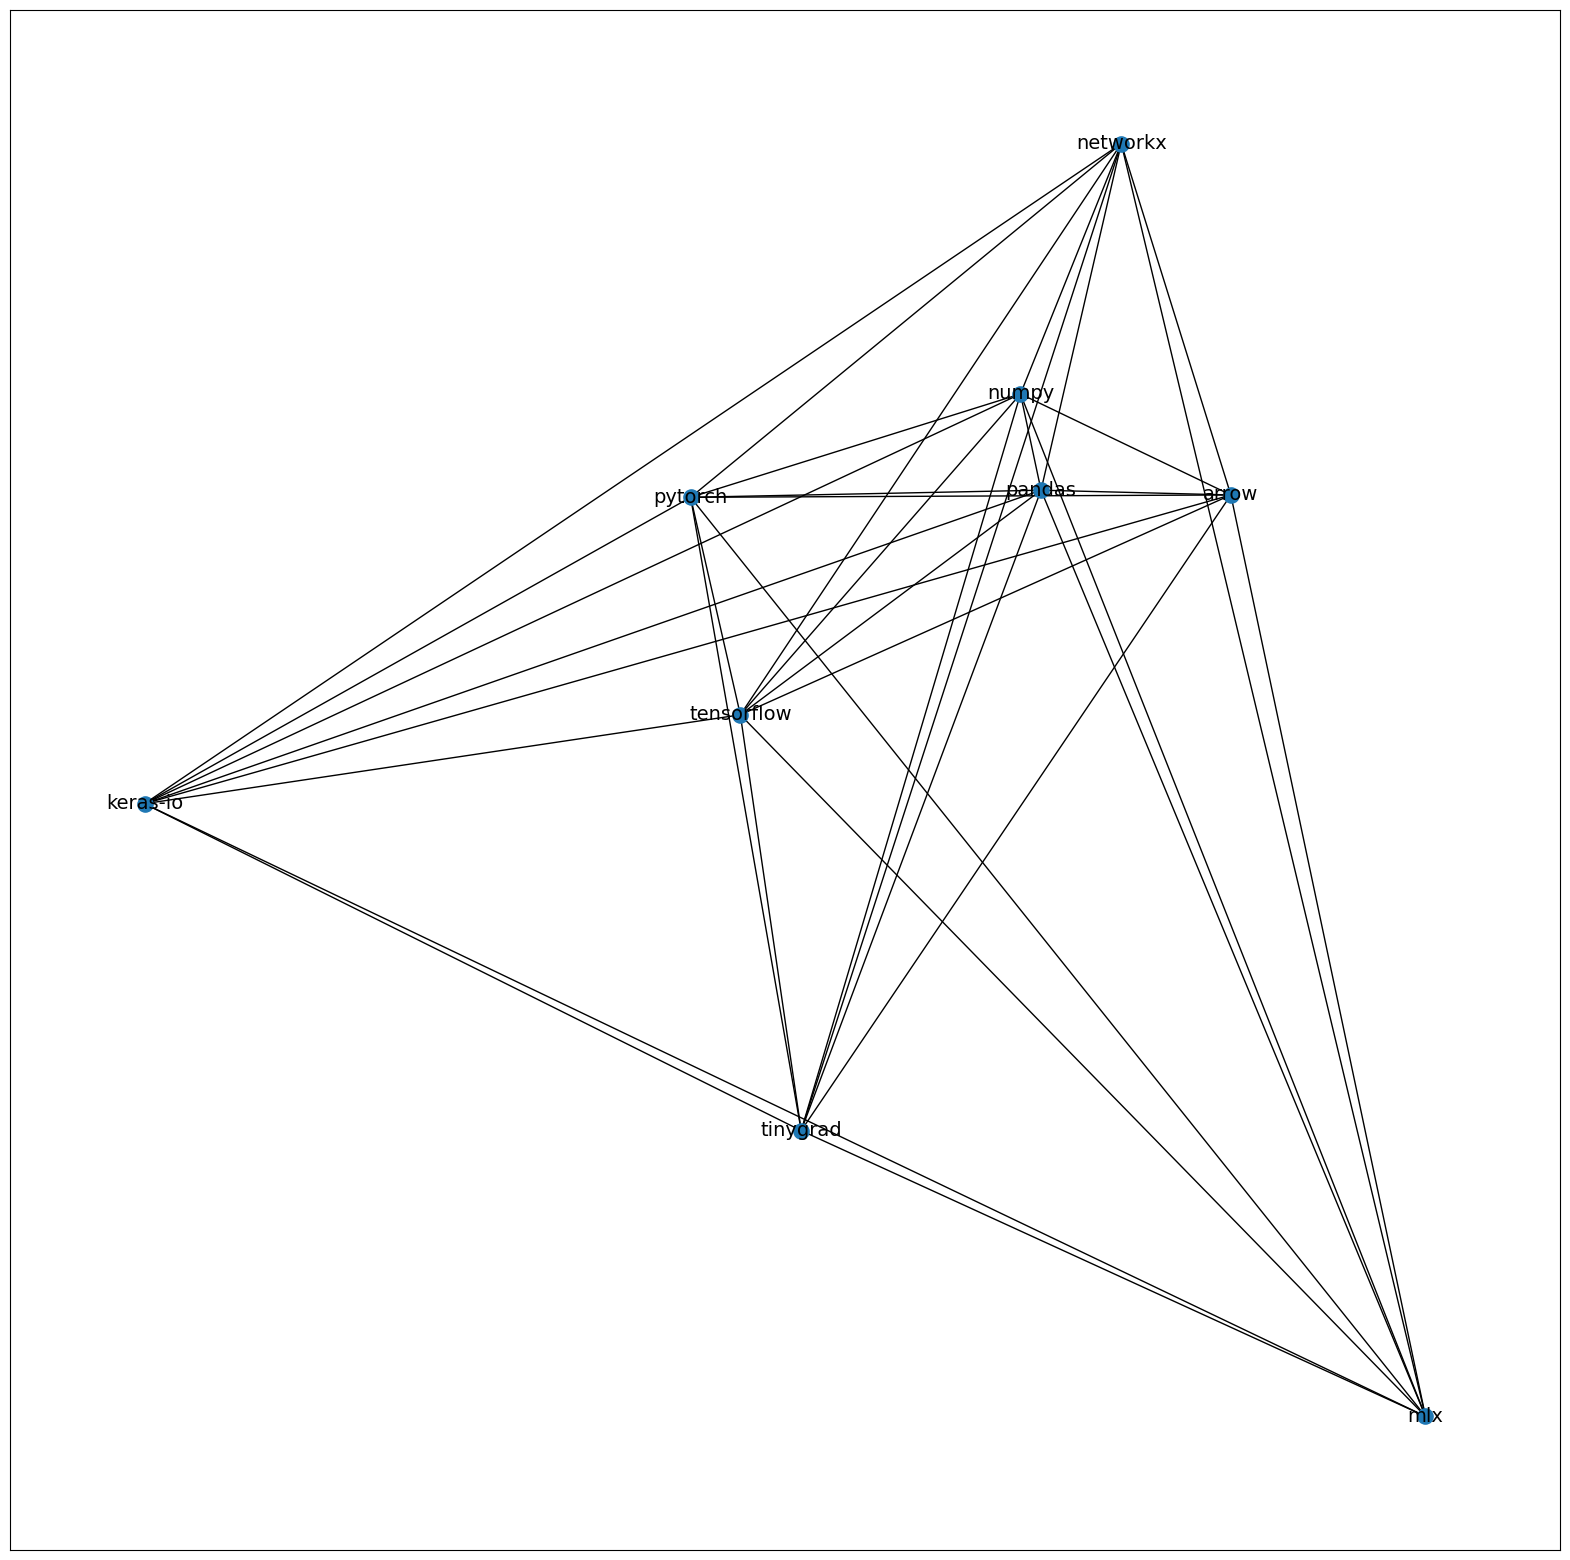

In [104]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(g, node_size=120, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If two nodes are close to each other, the two projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.

In [105]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Total execution time: {elapsed_time:.2f} seconds')


Total execution time: 305.56 seconds
